<pre style='font-size :25px; text-align: center'><b>ASSIGNMENT 1</b></pre>
<pre style='font-size :20px'><b>USING CLASSIFICATION MODELS TO SOLVE TITANIC CHALLENGE</b></pre>
<pre style='font-size :15px'>Welcome to your first assignment in classification module. Today your task is to solve a famous titanic challenge from kaggle. The stated problem is a binary classification, thus you will need to use classification models for solving this task. You will also be introduced to new metrics for classification and new approach of validating your model.</pre>

<pre style='font-size : 20px'><b>PART 1</b></pre>
<pre style='font-size : 18px'><b>Analysis and processing of data</b></pre>
<pre style='font-size : 15px;'>Firstly let's import necessary packages. </pre>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score

<pre style='font-size : 15px;'>For retriving the same results from our models we will set seed to 5.</pre>

In [4]:
sns.set()
seed=5

<pre style='font-size : 15px;'>Now let's load the data. The function load_data loads the titanic dataset and can be used both in yours and colab's environments. </pre>

In [5]:
def load_data(file):
    url = 'https://raw.githubusercontent.com/HikkaV/VNTU-ML-Courses/master/assignments/machine_learning/files/{}'.format(file)
    try:
        df = pd.read_csv(url)
    except:
        df = pd.read_csv('../files/{}'.format(file))
    return df

In [6]:
df = load_data('train.csv')

<pre style='font-size : 15px;'>Some notes about the dataset are shown below. </pre>

The partial description of Titanic dataset is situated below.
<pre>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
</pre>
<pre>
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
</pre>
Learn more about the  dataset <a href='https://www.kaggle.com/c/titanic/data'>here</a>

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<pre style='font-size : 15px;'>The function show_dependency plots the dependency between different values of features and target value.</pre>

In [6]:
def show_dependency(df,column_name,k=3):
    target = 'Survived'
    groups = df[column_name].unique()
    if len(groups)<k:
        k=len(groups)
    groups = groups[:k]
    df = df.groupby(column_name)
    fig, axes = plt.subplots(nrows=1, ncols=k, figsize=(14, 9))
    colors = dict({'Survived':'g','Died':'r'})
    for c,i in enumerate(groups):
        values = df.get_group(i)[target].values
        dead = [i for i in values if i==0]
        survived = [i for i in values if i==1]
        
        axes[c].bar(height=[len(survived),len(dead)],x=list(range(2)),color=list(colors.values
                                                                                 ()),
                   )

        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        axes[c].legend(handles, labels)
        axes[c].set_xlabel(i)

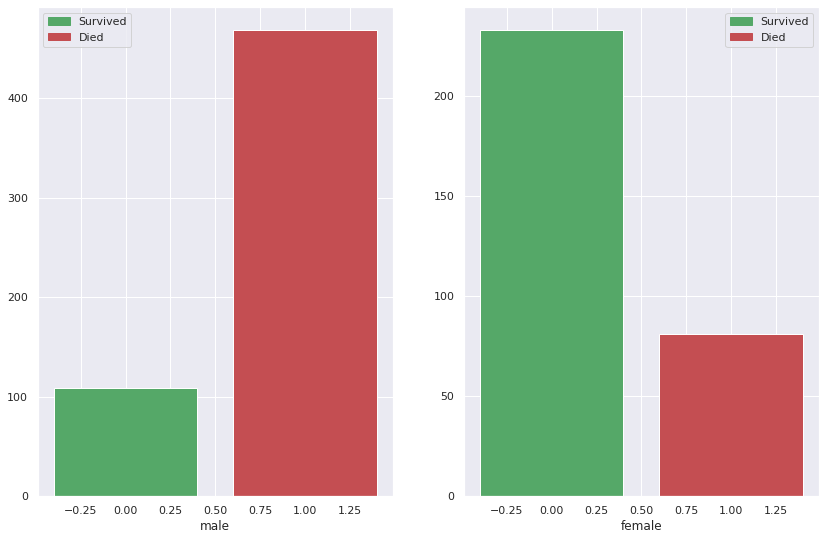

In [7]:
show_dependency(df,'Sex')

<pre style='font-size : 15px;'>One important thing to do is to understand if our dataset is balanced. Depending on this criteria, we will choose the metric for measuring the perfomance of our classifier.</pre>

In [8]:
def show_column(df,column_name,k=10):
    df[column_name].value_counts()[:10].plot.bar(figsize=(14,9),title=column_name)

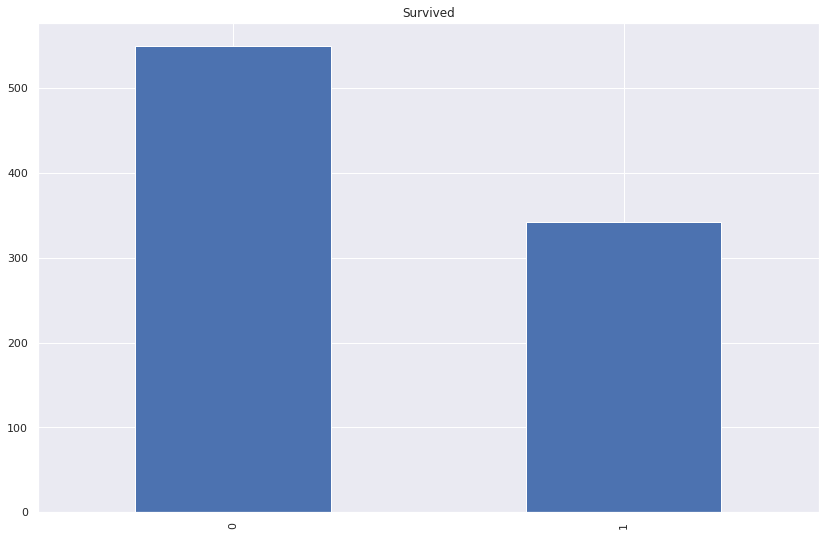

In [9]:
show_column(df,column_name='Survived')

<pre style='font-size : 15px;'>From the inset above it's obvious that our dataset is unbalanced, as there are much more people who died than who survived during the Titanic castastrophe. Based on this information the best choise is to use precision,recall or f1-score. For simplicity we will carry on with precision. </pre>

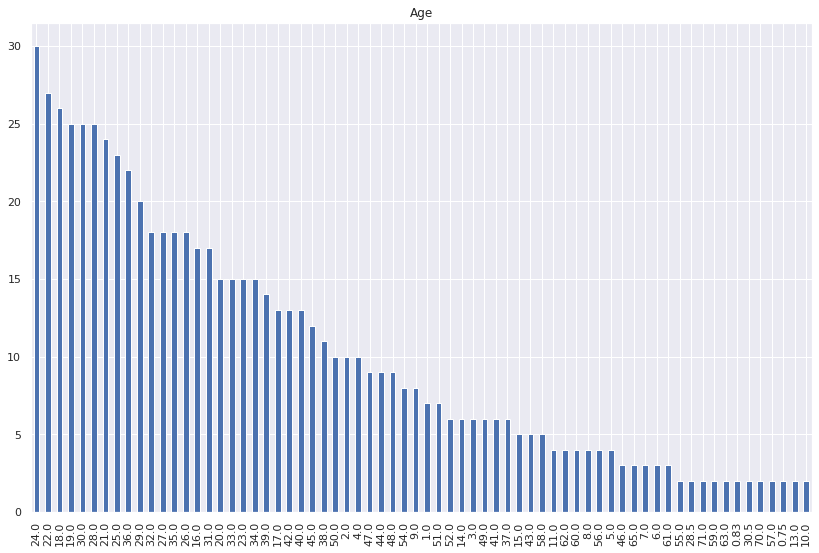

In [10]:
show_column(df,column_name='Age')

<pre style='font-size : 15px;'>We choose only those columns that we'd like to use. Remember that you should carefully choose the features for your classifier as some of them couldn't be available during prediction time.</pre>

In [11]:
columns_to_use = ['Survived','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

In [12]:
data_set = df[columns_to_use].copy()

In [13]:
target = columns_to_use.pop(0)

In [14]:
print(columns_to_use,target)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] Survived


<pre style='font-size : 15px;'>Some of our columns have NaN values. There are lots of solutions to this problem :</pre>
<li>Drop all the rows with NaN values.</li>
    <li>Fill NaN values with some unique token ('unknown' for string columns and a random number which is not in a column for numerical ones).</li>
    <li>Fill NaN values with statistics based values (mean or std for numerical ones) </li>
<pre style='font-size : 15px;'>For the small datasets it's unreasonable to drop data as every data point is benefitial. Also filling NaN values based on random variables isn't the best idea as it can add some noise to data. Thus we will use the last method. Filling NaN values is implemented in preprocess function. </pre>

In [15]:
def preprocess(df,column_to_use):
    for column_name in columns_to_use:
        
        try:
       
            df[column_name] = df[column_name].fillna(np.mean(df[column_name]))
        except:
        
            df[column_name] = df[column_name].fillna('unknown')
    return df

In [16]:
data_set = preprocess(data_set,columns_to_use)

In [17]:
data_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,unknown,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,unknown,S


<pre style='font-size : 15px;'>We should also convert our string columns to numerical values. At this point we can just map string values to integers. We also need to save the dicts with mapping in order to then use it during the prediction time. </pre>

In [18]:
columns_to_convert = ['Sex','Cabin','Embarked','Ticket']

In [19]:
def convert(df,columns_to_convert):
    dict_columns = {}
    for column_name in columns_to_convert:
        dict_column = dict((i,c) for c,i in enumerate(df[column_name].unique()))
        dict_columns.update({column_name:dict_column})
        df[column_name] = df[column_name].apply(lambda x: dict_column.get(x))
    return df,dict_columns

In [20]:
data_set,dict_columns = convert(data_set,columns_to_convert)

<pre style='font-size : 15px;'>There is also a need of constructing a new feature named Relatives which consists of two other features SibSp - number of sibiling/spouses and Parch - number of children. More features we have - better the classifier is trained.</pre>

In [21]:
data_set['Relatives'] = data_set['SibSp'] + data_set['Parch']

In [22]:
columns_to_use.append('Relatives')

In [23]:
data_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
0,0,3,0,22.0,1,0,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,1,71.2833,1,1,1
2,1,3,1,26.0,0,0,2,7.9250,0,0,0
3,1,1,1,35.0,1,0,3,53.1000,2,0,1
4,0,3,0,35.0,0,0,4,8.0500,0,0,0


<pre style='font-size : 15px;'>Finnaly, let's plot the correlation between features and target to get the insight about the data.</pre>

In [24]:
data_set.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
Survived,1.000000,-0.338481,0.543351,-0.069809,-0.035322,0.081629,-0.047298,0.257307,0.270495,0.118026,0.016639
Pclass,-0.338481,1.000000,-0.131900,-0.331339,0.083081,0.018443,-0.017489,-0.549500,-0.623554,0.028566,0.065997
Sex,0.543351,-0.131900,1.000000,-0.084153,0.114631,0.245489,-0.132709,0.182333,0.082104,0.128526,0.200988
Age,-0.069809,-0.331339,-0.084153,1.000000,-0.232625,-0.179191,0.120275,0.091566,0.216722,0.023578,-0.248512
SibSp,-0.035322,0.083081,0.114631,-0.232625,1.000000,0.414838,-0.303229,0.159651,-0.058893,-0.063794,0.890712
Parch,0.081629,0.018443,0.245489,-0.179191,0.414838,1.000000,-0.273002,0.216225,-0.003678,-0.082144,0.783111
Ticket,-0.047298,-0.017489,-0.132709,0.120275,-0.303229,-0.273002,1.000000,-0.142578,0.212438,-0.037227,-0.343634
Fare,0.257307,-0.549500,0.182333,0.091566,0.159651,0.216225,-0.142578,1.000000,0.397105,0.071010,0.217138
Cabin,0.270495,-0.623554,0.082104,0.216722,-0.058893,-0.003678,0.212438,0.397105,1.000000,0.016607,-0.042089
Embarked,0.118026,0.028566,0.128526,0.023578,-0.063794,-0.082144,-0.037227,0.071010,0.016607,1.000000,-0.084639


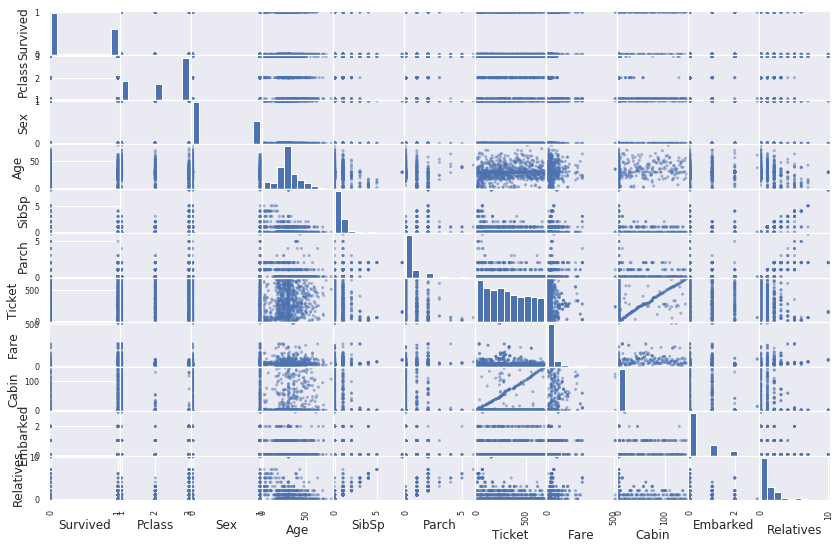

In [25]:
scatter_matrix(data_set,figsize=(14,9));

<pre style='font-size : 20px'><b>PART 2</b></pre>
<pre style='font-size : 18px'><b>Training classification models and validating them</b></pre>

<pre style='font-size : 15px'>First of all let's process all the data.</pre>

In [26]:
overall_X = MinMaxScaler().fit_transform(data_set[columns_to_use])
overall_y = data_set[target]

In [27]:
overall_X

array([[1.        , 0.        , 0.27117366, ..., 0.        , 0.        ,
        0.1       ],
       [0.        , 1.        , 0.4722292 , ..., 0.00680272, 0.33333333,
        0.1       ],
       [1.        , 1.        , 0.32143755, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.36792055, ..., 0.        , 0.        ,
        0.3       ],
       [0.        , 0.        , 0.32143755, ..., 1.        , 0.33333333,
        0.        ],
       [1.        , 0.        , 0.39683338, ..., 0.        , 0.66666667,
        0.        ]])

In [28]:
overall_y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

<pre style='font-size : 15px'>Now let's make the classifiers we will evaluate. For this time we won't dig into choosing the hyperparameters, thus we will initialize models with  only one parameter : random_state (for equality of the experiments' results). We then will validate the models with k-fold  cross  validation with respect to precision metric and choose the best.
</pre>

In [29]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [30]:
classifiers_dict = {'LogisticRegression':LogisticRegression(
    random_state=seed),'SVC': SVC(random_state=seed),
 'DecisionTreeClassifier': tree.DecisionTreeClassifier(random_state=seed),
 'RandomForestClassifier':RandomForestClassifier(random_state=seed),
 'GradientBoostingClassifier':GradientBoostingClassifier(random_state=seed)
}

<pre style='font-size : 15px'>The function choose_best_classifier applies greed search to choose the best classifier with respect to cross validation result using the defined metric.
</pre>

In [31]:
def choose_best_classifier(classifiers_dict,data_X,data_y,scoring='precision'):
    best_precision = 0
    best_clf = None
    for name, clf in classifiers_dict.items():
        scores = scores_precision = cross_val_score(clf, data_X,data_y, cv=5, scoring=scoring)
        mean_scores = np.mean(scores)
        print('Classifier : {0}, mean {1} : {2}'.format(name, scoring,mean_scores))
        if mean_scores>best_precision:
            best_precision=mean_scores
            best_clf = (name,clf)
    print('Best classifier : {0}, mean {1} : {2} '.format(best_clf[0],scoring,best_precision))
    return best_clf

In [32]:
best_clf =choose_best_classifier(classifiers_dict,overall_X,overall_y)

/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Classifier : LogisticRegression, mean precision : 0.7375267094017095
Classifier : SVC, mean precision : 0.7435782967032967
Classifier : DecisionTreeClassifier, mean precision : 0.6993752598140558
Classifier : RandomForestClassifier, mean precision : 0.7677638020637192
Classifier : GradientBoostingClassifier, mean precision : 0.8189736070381232
Best classifier : GradientBoostingClassifier, mean precision : 0.8189736070381232 


In [33]:
best_clf

('GradientBoostingClassifier',
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=5, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False))

In [34]:
best_clf =choose_best_classifier(classifiers_dict,overall_X,overall_y,'recall')

Classifier : LogisticRegression, mean recall : 0.7134271099744246
Classifier : SVC, mean recall : 0.6809889173060528
Classifier : DecisionTreeClassifier, mean recall : 0.6726342710997442
Classifier : RandomForestClassifier, mean recall : 0.6846547314578005


/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Classifier : GradientBoostingClassifier, mean recall : 0.7106564364876384
Best classifier : LogisticRegression, mean recall : 0.7134271099744246 


In [35]:
best_clf

('LogisticRegression',
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=5, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False))

<pre style='font-size : 15px'>For different metric we got different results using greed search. The best classifier with respect to cross validation precision score is GradientBoostedTress, whereas the best classifier with respect to crosss validation recall score is LogisticRegression. To understand what is actually the bestt classifier we should make greed search with respect to f1 score.
</pre>

In [36]:
best_clf =choose_best_classifier(classifiers_dict,overall_X,overall_y,'f1')

Classifier : LogisticRegression, mean f1 : 0.724454709331733
Classifier : SVC, mean f1 : 0.7102403413210931
Classifier : DecisionTreeClassifier, mean f1 : 0.683766759119649
Classifier : RandomForestClassifier, mean f1 : 0.7202572992402515


/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Classifier : GradientBoostingClassifier, mean f1 : 0.7598654308421843
Best classifier : GradientBoostingClassifier, mean f1 : 0.7598654308421843 


<pre style='font-size : 15px'>Finnaly, GradientBoostingClassifier showed the best result. 
</pre>

In [37]:
name, clf = best_clf

In [38]:
clf.fit(overall_X,overall_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=5, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

<pre style='font-size : 20px'><b>PART 3</b></pre>
<pre style='font-size : 18px'><b>Making predictions kaggle</b></pre>

<pre style='font-size : 15x'>Now that we choose the best classifier and trained it on all the data, we are ready to make prediction on an unseen test set and submmit results to kaggle.First of all we will load our test data and process it as the train one.</pre>

In [77]:
test = load_data('test.csv')

In [78]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [79]:
submission_form = test.copy()

In [80]:
relatives_column = columns_to_use.pop(columns_to_use.index('Relatives'))

ValueError: 'Relatives' is not in list

In [81]:
relatives_column

'Relatives'

In [82]:
test_set = preprocess(test,columns_to_use)

In [83]:
test_set

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,unknown,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,unknown,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,unknown,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,unknown,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,unknown,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,unknown,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,unknown,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,unknown,S


In [84]:
columns_to_convert

['Sex', 'Cabin', 'Embarked', 'Ticket']

<pre style='font-size : 15x'>Now we should convert the string columns to numerical using the saved dict with mapping.</pre>

In [85]:
def convert_for_predict(df, columns_to_convert,dict_convert):
    for i in columns_to_convert:
        dict_column = dict_convert.get(i)
        df[i] = df[i].apply(lambda x: dict_column.get(x))
        df[i] = df[i].fillna(df[i].mean())
    return df

In [86]:
test_set = convert_for_predict(test_set,columns_to_convert,dict_columns)

In [87]:
test_set

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.50000,0,0,290.348684,7.8292,0.000000,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,290.348684,7.0000,0.000000,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,290.348684,9.6875,0.000000,2
3,895,3,"Wirz, Mr. Albert",0,27.00000,0,0,290.348684,8.6625,0.000000,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,405.000000,12.2875,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,30.27259,0,0,290.348684,8.0500,0.000000,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,273.000000,108.9000,7.634409,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,290.348684,7.2500,0.000000,0
416,1308,3,"Ware, Mr. Frederick",0,30.27259,0,0,290.348684,8.0500,0.000000,0


In [88]:
test_set = test_set[columns_to_use]

<pre style='font-size : 15x'>Finnaly, we will construct the Relatives feature and predict on our data.</pre>

In [89]:
test_set['Relatives'] = test_set['SibSp']+test_set['Parch']

/home/volodymyr/envs/courses_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
test_set.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
0,3,0,34.5,0,0,290.348684,7.8292,0.0,2,0
1,3,1,47.0,1,0,290.348684,7.0000,0.0,0,1
2,2,0,62.0,0,0,290.348684,9.6875,0.0,2,0
3,3,0,27.0,0,0,290.348684,8.6625,0.0,0,0
4,3,1,22.0,1,1,405.000000,12.2875,0.0,0,2


In [92]:
prediction = clf.predict(test_set)

In [93]:
submission_form['Survived'] = prediction

In [94]:
submission_form=submission_form[['PassengerId','Survived']]

<pre style='font-size : 15x'>Our submission form should be of following form :</pre>

In [96]:
submission_form.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


<pre style='font-size : 15x'>Finnaly, we can save the submssion to then submit it to <a href='https://www.kaggle.com/c/titanic'>titanic</a> compettion on kaggle.</pre>

In [76]:
submission_form.to_csv('submission.csv',index=False)

<pre style='font-size : 15x'>In this notebook we made a really heavy job. Firstly, we loaded, processed and analysed the data. Then we used classification models with default parameters and applied greed search to find the best one with respect to cross validation score on specific metric. Actually submitting this results to kaggle will only give a score of 66%, but it's a nice start. In the next notebook we will try to get even better results by searching for best hyperparameters. </pre>